# Trying course solvers on NLS Problems

In [4]:
using ADNLPModels

nlp = ADNLPModel(
  x -> (x[1] - 1)^2 + 4 * (x[2] - x[1]^2)^2, # function
  [-1.2; 1.0] # starting point
)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  EmptyADbackend,
  EmptyADbackend,
  EmptyADbackend,
  ForwardDiffADHessian,
  EmptyADbackend,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                            

In [2]:
using NLPModels
using LinearAlgebra

### A - Modified Newton $B_k = \nabla ^2 f(x_k)+\rho I$

In [3]:
using SolverCore

function newton_modified_ρ(
  nlp :: AbstractNLPModel; # Only mandatory argument, notice the ;
  max_time :: Float64 = 30.0, # maximum allowed time
  max_iter :: Int = 100 # maximum allowed iterations
  )

  x = copy(nlp.meta.x0) # starting point
  α = 1e-2 # Armijo parameter
  ρ = 0.0

  iter = 0
  t₀ = time()
  Δt = time() - t₀
  status = :unknown
  tired = Δt ≥ max_time > 0 || iter ≥ max_iter > 0
  solved = norm(grad(nlp, x)) ≤ 1e-6
  while !(solved || tired)

    # Computing the direction
    B = Symmetric(hess(nlp, x), :L)
    factor = cholesky(B + ρ * I, check=false)
    while !issuccess(factor)
      ρ = max(1e-8, 10ρ)
      factor = cholesky(B + ρ * I, check=false)
    end
    d = factor \ -grad(nlp, x)

    # Computing the step length
    t = 1.0
    fx = obj(nlp, x)
    ft = obj(nlp, x + t * d)
    slope = dot(grad(nlp, x), d)
    while !(ft ≤ fx + α * t * slope)
      t *= 0.5
      ft = obj(nlp, x + t * d)
    end

    x += t * d

    iter += 1
    Δt = time() - t₀
    tired = Δt ≥ max_time > 0 || iter ≥ max_iter > 0
    solved = norm(grad(nlp, x)) ≤ 1e-6
  end

  if solved
    status = :first_order
  elseif tired
    if Δt ≥ max_time > 0
      status = :max_time
    elseif iter ≥ max_iter > 0
      status = :max_iter
    end
  end

  return GenericExecutionStats(nlp, status=status, solution=x, objective=obj(nlp, x), iter=iter, elapsed_time=Δt)

end

newton_modified_ρ (generic function with 1 method)

In [5]:
output = newton_modified_ρ(nlp)

println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 7.141610295610004e-18
  primal feasibility: 0.0
  dual feasibility: Inf
  solution: [0.9999999973418803  0.9999999945459112]
  iterations: 9
  elapsed time: 9.001325845718384


### B - Modified Newton $B_k = LDL^T$

In [6]:
function armijo(xk, dk, fk, gk, f)
    slope = dot(gk, dk) #doit être <0
    t = 1.0
    while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5 end
    return t end

armijo (generic function with 1 method)

In [15]:
using LDLFactorizations

function newton_modified_ldlt(
    nlp :: AbstractNLPModel; # Only mandatory argument, notice the ;
    max_time :: Float64 = 30.0, # maximum allowed time
    max_iter :: Int = 100 # maximum allowed iterations
    ) 


    xk = copy(nlp.meta.x0)
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k=0


    t₀ = time()
    Δt = time() - t₀
    status = :unknown
    tired = Δt ≥ max_time > 0 || k ≥ max_iter > 0
    solved = gnorm ≤ 1.0e-6 + 1.0e-6 * gnorm0
    
    while !(solved || tired) # && fk > -1e15
        Hk = Symmetric(triu(hess(nlp, xk)), :U) 
        Sk = ldl_analyze(Hk)
        ldl_factorize!(Hk, Sk)
        dk = - Sk \ gk
        α = armijo(xk, dk, fk, gk, x -> obj(nlp, x)) 
        xk += α * dk
        fk = obj(nlp, xk)
        gk = grad(nlp, xk)
        gnorm = norm(gk)

        k += 1
        Δt = time() - t₀
        tired = Δt ≥ max_time > 0 || k ≥ max_iter > 0
        solved = gnorm ≤ 1.0e-6 + 1.0e-6 * gnorm0

    end
    if solved
        status = :first_order
    elseif tired
        if Δt ≥ max_time > 0
          status = :max_time
        elseif k ≥ max_iter > 0
          status = :max_iter
        end
    end
    
    return GenericExecutionStats(nlp, status=status, solution=xk, objective=obj(nlp, xk), iter=k, elapsed_time=Δt)
end

newton_modified_ldlt (generic function with 2 methods)

In [16]:
output = newton_modified_ldlt(nlp)

println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 7.141610295610004e-18
  primal feasibility: 0.0
  dual feasibility: Inf
  solution: [0.9999999973418803  0.9999999945459112]
  iterations: 9
  elapsed time: 0.03821992874145508


### C - Quasi Newton BFGS

In [22]:
function quasi_newton_bfgs(
    nlp :: AbstractNLPModel; # Only mandatory argument, notice the ;
    max_time :: Float64 = 30.0, # maximum allowed time
    max_iter :: Int = 100 # maximum allowed iterations
  )
    
    xk = copy(nlp.meta.x0)
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    Hk = I(length(xk))
    gnorm = gnorm0 = norm(gk)
    k=0
    
    k=0
    t₀ = time()
    Δt = time() - t₀
    status = :unknown
    tired = Δt ≥ max_time > 0 || k ≥ max_iter > 0
    solved = gnorm ≤ 1.0e-6 + 1.0e-6 * gnorm0

    while !(solved || tired) # && fk > -1e15
        dk = -Hk * gk
        α = armijo(xk, dk, fk, gk, x -> obj(nlp, x)) 
        sk = α*dk
        xk += sk
        new_fk = obj(nlp, xk)
        new_gk = grad(nlp, xk)
        yk = new_gk - gk
        if yk' * sk > 0
            ρk = 1 / dot(yk, sk)
            Hk = (I - ρk * sk * yk') * Hk * (I - ρk * yk * sk') + ρk * sk * sk' 
        end
        fk, gk = new_fk, new_gk
        gnorm = norm(gk)

        k += 1
        Δt = time() - t₀
        tired = Δt ≥ max_time > 0 || k ≥ max_iter > 0
        solved = gnorm ≤ 1.0e-6 + 1.0e-6 * gnorm0
    end
    if solved
        status = :first_order
      elseif tired
        if Δt ≥ max_time > 0
          status = :max_time
        elseif k ≥ max_iter > 0
          status = :max_iter
        end
    end
    return GenericExecutionStats(nlp, status=status, solution=xk, objective=obj(nlp, xk), iter=k, elapsed_time=Δt)
end

quasi_newton_bfgs (generic function with 1 method)

In [23]:
output = quasi_newton_bfgs(nlp)

println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 3.207237118019132e-12
  primal feasibility: 0.0
  dual feasibility: Inf
  solution: [0.9999983346739613  0.9999963399852823]
  iterations: 10
  elapsed time: 0.030742883682250977


### D - Benchmarking

In [24]:
using JSOSolvers

output = lbfgs(nlp)
print(output)

Generic Execution stats
  status: first-order stationary
  objective value: 2.239721910559509e-18
  primal feasibility: 0.0
  dual feasibility: 4.018046284781729e-9
  solution: [0.9999999986742657  0.9999999970013461]
  iterations: 18
  elapsed time: 0.0018038749694824219


In [25]:
using NLSProblems
problems_names = setdiff(names(NLSProblems), [:NLSProblems])
problems = (eval((problem))() for problem ∈ problems_names)

Base.Generator{Vector{Symbol}, var"#37#38"}(var"#37#38"(), [:BNST2, :BNST3, :LVcon501, :LVcon502, :LVcon503, :LVcon504, :LVcon511, :LVcon512, :LVcon513, :LVcon514  …  :tp354, :tp355, :tp358, :tp370, :tp371, :tp372, :tp373, :tp379, :tp394, :tp395])

In [ ]:
using SolverBenchmark

solvers = Dict(:newton_modified_ρ => newton_modified_ρ, :newton_modified_ldlt => newton_modified_ldlt, :quasi_newton_bfgs => quasi_newton_bfgs, :lbfgs => lbfgs)
stats = bmark_solvers(solvers, problems)

In [27]:
cols = [:name, :status, :objective, :elapsed_time, :iter]
pretty_stats(stats[:newton_modified_ρ][!, cols])

┌───────────────────┬─────────────┬───────────┬──────────────┬────────┐
│              name │      status │ objective │ elapsed_time │   iter │
├───────────────────┼─────────────┼───────────┼──────────────┼────────┤
│             BNST2 │   exception │       Inf │          Inf │      0 │
│             BNST3 │   exception │       Inf │          Inf │      0 │
│  Lukšan-Vlček 5.1 │ first_order │  1.99e+00 │     6.13e-02 │     87 │
│  Lukšan-Vlček 5.2 │ first_order │ -8.53e-14 │     4.34e-03 │     42 │
│  Lukšan-Vlček 5.3 │ first_order │  1.76e-10 │     1.10e-03 │     17 │
│  Lukšan-Vlček 5.4 │ first_order │  1.75e+00 │     3.62e-03 │     14 │
│ Lukšan-Vlček 5.11 │ first_order │  3.14e-09 │     8.26e-04 │     13 │
│ Lukšan-Vlček 5.12 │ first_order │  3.49e-09 │     8.35e-04 │     14 │
│ Lukšan-Vlček 5.13 │ first_order │  1.31e-09 │     8.10e-04 │     15 │
│ Lukšan-Vlček 5.14 │ first_order │  5.54e-09 │     1.20e-03 │     22 │
│ Lukšan-Vlček 5.15 │ first_order │  2.05e-09 │     1.22e-03 │  

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /Users/jules/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


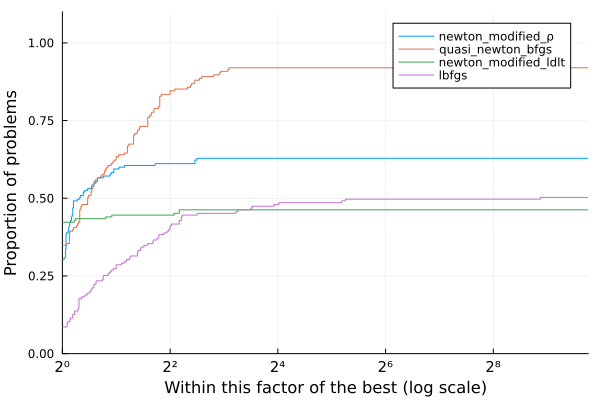

In [29]:
cost(df) = (df.status .!= :first_order) * Inf + df.iter
performance_profile(stats, cost)